In [1]:
# verwendete Libraries:
import pandas as pd
import numpy as np
from scipy.linalg import lstsq
from scipy.spatial.transform import Rotation as R
# zum Plotten:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

In [2]:
# relevante Punkte und Verbindungen im Mediapipe-Mesh werden übergeben:
facemesh_connections = [
    (0, 267), (7, 163), (10, 338), (13, 312), (14, 317), (17, 314), (21, 54),
    (33, 7), (33, 246), (37, 0), (39, 37), (40, 39), (46, 53), (52, 65),
    (53, 52), (54, 103), (58, 132), (61, 146), (61, 185), (63, 105), (65, 55),
    (66, 107), (67, 109), (70, 63), (78, 95), (78, 191), (80, 81), (81, 82),
    (82, 13), (84, 17), (87, 14), (88, 178), (91, 181), (93, 234), (95, 88),
    (103, 67), (105, 66), (109, 10), (127, 162), (132, 93), (136, 172),
    (144, 145), (145, 153), (146, 91), (148, 176), (149, 150), (150, 136),
    (152, 148), (153, 154), (154, 155), (155, 133), (157, 173), (158, 157),
    (159, 158), (160, 159), (161, 160), (162, 21), (163, 144), (172, 58),
    (173, 133), (176, 149), (178, 87), (181, 84), (185, 40), (191, 80),
    (234, 127), (246, 161), (249, 390), (251, 389), (263, 249), (263, 466),
    (267, 269), (269, 270), (270, 409), (276, 283), (282, 295), (283, 282),
    (284, 251), (288, 397), (293, 334), (295, 285), (296, 336), (297, 332),
    (300, 293), (310, 415), (311, 310), (312, 311), (314, 405), (317, 402),
    (318, 324), (321, 375), (323, 361), (324, 308), (332, 284), (334, 296),
    (338, 297), (356, 454), (361, 288), (365, 379), (373, 374), (374, 380),
    (375, 291), (377, 152), (378, 400), (379, 378), (380, 381), (381, 382),
    (382, 362), (384, 398), (385, 384), (386, 385), (387, 386), (388, 387),
    (389, 356), (390, 373), (397, 365), (398, 362), (400, 377), (402, 318),
    (405, 321), (409, 291), (415, 308), (454, 323), (466, 388)
]

LEFT_EYE = [7, 33, 133, 144, 145, 153, 154, 155,
            157, 158, 159, 160, 161, 163, 173, 246]

RIGHT_EYE = [249, 263, 362, 373, 374, 380, 381, 382,
             384, 385, 386, 387, 388, 390, 398, 466]

LIPS = [0, 13, 14, 17, 37, 39, 40, 61, 78, 80, 81, 82, 84, 87, 88, 91, 95, 146,
        178, 181, 185, 191, 267, 269, 270, 291, 308, 310, 311, 312, 314, 317,
        318, 321, 324, 375, 402, 405, 409, 415]

In [16]:
# Das rohe Facemesh wird eingelesen und als Pandas-Dataframe vorbereitet
df = pd.read_csv(filepath_or_buffer="results_facemesh.csv",
                 dtype={"relative_filepath": str, "facs_str": str}
                 #zu Testzwecken nur einen Ausschnitt einlesen
                 , nrows=100 
                    )

df = df[~df.l_1_x.isnull()]

# Alles außer XYZ-Koordinaten wird entfernt
X_all = df[[*[col for col in df.columns if "_x" in col or "_y" in col or "_z" in col]]].values
# Matrix für Koordinatentransformation wird initialisiert:
X, Y, Z = X_all[1].reshape(468, 3).T

In [17]:
def get_euler_angles(X, Y, Z):
    # Die Koordinaten werden an einem Nullpunkt ausgerichtet:
    xmean, ymean, zmean = np.mean(X), np.mean(Y), np.mean(Z)
    X -= xmean
    Y -= ymean
    Z -= zmean


    # Die folgenden Funktionen werden global verfügbar gemacht, um den nachfolgenden Plot zu ermöglichen:
    global line_points, z_func
    
    # Für die Schätzung der Lagewinkel werden die Augenkoordinaten links und rechts und später die Ebene zwischen Augen und Lippen herangezogen:
    eyes_data = np.concatenate((X[LEFT_EYE + RIGHT_EYE][:, None],
                                Y[LEFT_EYE + RIGHT_EYE][:, None],
                                Z[LEFT_EYE + RIGHT_EYE][:, None]),
                               axis=1)
    data_mean = eyes_data.mean(axis=0)

    
    uu, dd, vv = np.linalg.svd(eyes_data - data_mean)
    line_points = vv[0] * np.mgrid[-1:1:2j][:, None]
    line_points += data_mean
    eyeline_triangle_ab = np.squeeze(np.diff(line_points[:, :-1], axis=0))
    roll_angle = np.arctan(eyeline_triangle_ab[1] / eyeline_triangle_ab[0])
    print(f"Roll angle = {roll_angle / np.pi * 180:.3f} deg")
    A = np.matrix(np.vstack([X, Y, np.ones_like(Z)])).T
    fit, residual, rnk, s = lstsq(A, Z.T)
    print(f"Plane fit: z = {fit[0]:+.3f}*x{fit[1]:+.3f}*y{fit[2]:.3f}")
    yaw_angle = -np.arctan(fit[0])
    pitch_angle = np.arctan(fit[1])
    print(f"Yaw angle = {yaw_angle / np.pi * 180:.3f} deg")
    print(f"Pitch angle = {pitch_angle / np.pi * 180:.3f} deg")

    return pitch_angle, yaw_angle, roll_angle

def rotate_xyz(X, Y, Z, pitch_angle, yaw_angle, roll_angle):
    # Die 3D-Rotation wird durchgeführt:
    r = R.from_euler("xyz", [pitch_angle, yaw_angle, roll_angle])
    # Die folgenden Funktionen werden global verfügbar gemacht, um den nachfolgenden Plot zu ermöglichen:
    global X_rot, Y_rot, Z_rot
    
    X_rot, Y_rot, Z_rot = np.dot(np.vstack([X, Y, Z]).T, r.as_matrix()).T
    return np.array([X_rot, Y_rot, Z_rot]).T.reshape(468*3)

(-0.1052532564809763, 0.21741901152224904)

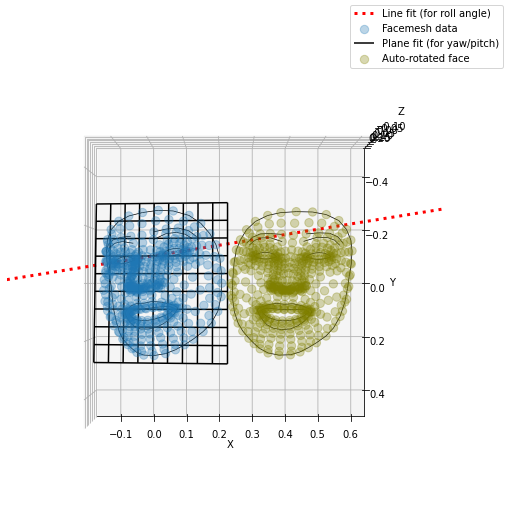

In [45]:
%matplotlib inline

fig = plt.figure(f"Rotating head", figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-90, azim=-90)
# Facemesh
ax.scatter(X, Y, Z, s=70, alpha=0.3, label="Facemesh data")
# Gesichtsrahmen:
lines3d = []
for i, j in facemesh_connections:
    lines3d.append([(X[i], Y[i], Z[i]), (X[j], Y[j], Z[j])])

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

# Augenlinie: 
ax.plot3D(*line_points.T, "r:", lw=3, label="Line fit (for roll angle)")
# Ebene:
Xplane, Yplane = np.meshgrid(np.linspace(xlim[0], xlim[1], 10),
                             np.linspace(ylim[0], ylim[1], 10))
Zplane = zfunc(Xplane, Yplane)
ax.plot_wireframe(Xplane, Yplane, Zplane, color='k', label="Plane fit (for yaw/pitch)")


# Gedrehtes Facemesh zur besseren Sichtbarkeit verschieben:
X_rot += .4

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Gesichtsumrandung:
lines3drot = []
for i, j in facemesh_connections:
    lines3drot.append([(X_rot[i], Y_rot[i], Z_rot[i]), (X_rot[j], Y_rot[j], Z_rot[j])])

lc = Line3DCollection(lines3d, colors="k", linewidths=.7)
ax.add_collection(lc)
lcrot = Line3DCollection(lines3drot, colors="k", linewidths=.7)
ax.add_collection(lcrot)

ax.scatter(X_rot, Y_rot, Z_rot, c="olive", s=70, alpha=0.3, label="Auto-rotated face")

fig.legend()

ax.set_xlim(xlim[0], xlim[1] + 0.4)
ax.set_ylim(ylim[0] - .2, ylim[1] + .2)
ax.set_zlim(*zlim)

In [46]:
# Array initialisieren:
X_norm = np.zeros((1,1404))

# XYZ-Koordinaten anpassen:
for i in X_all:
    X, Y, Z = i.reshape(468, 3).T
    pitch, yaw, roll = get_euler_angles(X, Y, Z)
    processed_features = rotate_xyz(X, Y, Z, pitch, yaw, roll)
    X_norm=np.vstack([X_norm,processed_features])

# überflüssige Zeile entfernen:
X_norm=np.delete(X_norm, 0, 0)


np.savetxt('X_norm-10.txt', X_norm)

Roll angle = 0.930 deg
Plane fit: z = -0.201*x-0.083*y-0.000
Yaw angle = 11.382 deg
Pitch angle = -4.728 deg
Roll angle = 0.942 deg
Plane fit: z = -0.202*x-0.083*y-0.000
Yaw angle = 11.404 deg
Pitch angle = -4.728 deg
Roll angle = 1.614 deg
Plane fit: z = -0.202*x-0.078*y-0.000
Yaw angle = 11.418 deg
Pitch angle = -4.436 deg
Roll angle = 1.420 deg
Plane fit: z = -0.204*x-0.077*y0.000
Yaw angle = 11.504 deg
Pitch angle = -4.412 deg
Roll angle = 1.332 deg
Plane fit: z = -0.206*x-0.078*y-0.000
Yaw angle = 11.629 deg
Pitch angle = -4.474 deg
Roll angle = 2.280 deg
Plane fit: z = -0.202*x-0.073*y0.000
Yaw angle = 11.430 deg
Pitch angle = -4.149 deg
Roll angle = 2.015 deg
Plane fit: z = -0.212*x-0.080*y0.000
Yaw angle = 11.953 deg
Pitch angle = -4.576 deg
Roll angle = 1.793 deg
Plane fit: z = -0.211*x-0.077*y0.000
Yaw angle = 11.942 deg
Pitch angle = -4.414 deg
Roll angle = 1.753 deg
Plane fit: z = -0.208*x-0.075*y0.000
Yaw angle = 11.728 deg
Pitch angle = -4.278 deg
Roll angle = 2.001 deg
P